# Batch run each dataset from cellxgene

In [2]:
import os
import scanpy as sc
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import gc


## Set parameters and paths

In [3]:
# Define parameters
res = 1
n_hvg = 2000

In [4]:
# Define the input and output directories
input_dir = 'Input_files'
output_dir = 'Output_Johansen_2023_DS12'

# Create the output directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Get the list of files in the input directory
files = os.listdir(input_dir)
files

['DS12_2.h5ad',
 'DS13.h5ad',
 'DS1_1.h5ad',
 'DS3_1.h5ad',
 'DS3_2.h5ad',
 'DS1_3.h5ad',
 'DS1_2.h5ad',
 'DS3_3.h5ad',
 'DS2.h5ad',
 'DS9.h5ad',
 'DS12_1.h5ad',
 'DS1_4.h5ad',
 'DS8.h5ad']

## Analysis for microglia and oligodendrocytes¶
DS12_1 and DS12_2 combined

#### Merge dataset

In [5]:
# Load the .h5ad files
adata1 = sc.read_h5ad(os.path.join(input_dir,'DS12_1.h5ad'))
adata2 = sc.read_h5ad(os.path.join(input_dir,'DS12_2.h5ad'))
adata1.var["mt"]=adata1.var_names.str.startswith("MT-")
adata2.var["mt"]=adata2.var_names.str.startswith("MT-")

In [9]:
import anndata as ad
# Check for duplicate var_names
if not adata1.var_names.is_unique:
    print("Duplicate var_names in DS12_1:")
    print(adata1.var_names[adata1.var_names.duplicated()].tolist())
if not adata2.var_names.is_unique:
    print("Duplicate var_names in DS12_2:")
    print(adata2.var_names[adata2.var_names.duplicated()].tolist())

# Ensure unique obs_names by appending dataset identifier
adata1.obs_names = [f"DS12_1_{name}" for name in adata1.obs_names]
adata2.obs_names = [f"DS12_2_{name}" for name in adata2.obs_names]

# Remove duplicate var_names if needed
adata1.var = adata1.var[~adata1.var.index.duplicated(keep='first')]
adata2.var = adata2.var[~adata2.var.index.duplicated(keep='first')]

print(adata1.var.shape)

# Check whether variable names are identical
feature_name_adata1 = adata1.var['feature_name']
feature_name_adata2 = adata2.var['feature_name']
# Check if they are identical
if feature_name_adata1.equals(feature_name_adata2):
    print("The feature names in adata1 and adata2 are identical.")
else:
    print("The feature names in adata1 and adata2 are NOT identical.")

# Combine two datasets
adata = ad.concat([adata1, adata2], axis=0, join='outer', label='dataset', keys=['DS12_1', 'DS12_2'])

(18786, 18)
The feature names in adata1 and adata2 are identical.


In [10]:
del adata1
del adata2

In [11]:
pd.crosstab(index=adata.obs['Subclass'], columns='count')

col_0,count
Subclass,
Microglia-PVM,3934
Oligodendrocyte,57855


#### Preprocess and clustering

    Start QC


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    After process: number of obs 61780, number of var 18742
    It is Normalized and Log-Transformed data, no need to run normalization


/Users/yelin.zhao/opt/anaconda3/envs/py3_9_R4_30/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]
/Users/yelin.zhao/opt/anaconda3/envs/py3_9_R4_30/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:553: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


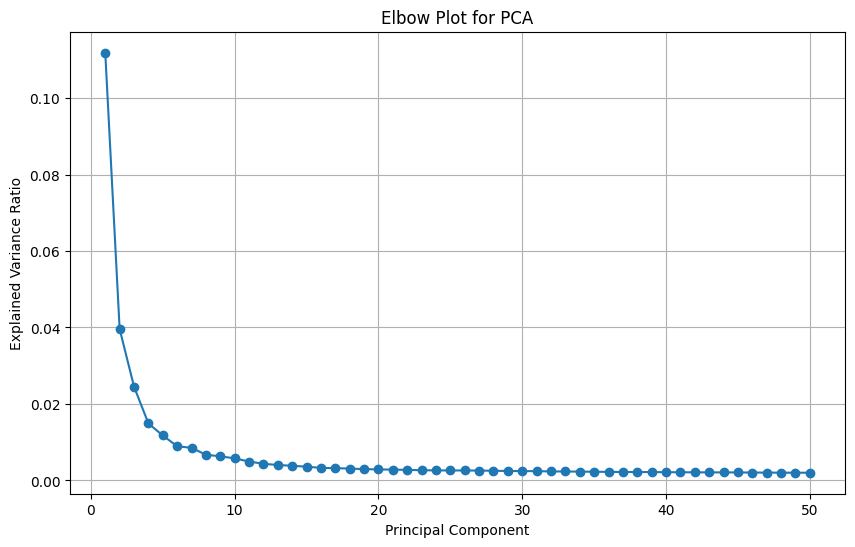

/Users/yelin.zhao/opt/anaconda3/envs/py3_9_R4_30/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
studyID='DS12'

adata.var['feature_name'] = feature_name_adata1
adata.var['GeneID']=adata.var.index
adata.var.set_index('feature_name',inplace=True)
if adata.raw is not None:
    adata.raw.var.index = adata.var.index
else:
    print("    adata.raw is None, skipping setting index.")
adata.var["mt"]=adata.var_names.str.startswith("MT-")

adata.obs['nCount_RNA'] = adata.obs['Number of UMIs']
adata.obs['nFeature_RNA'] = adata.obs['Genes detected']
del adata.obs['Number of UMIs']
del adata.obs['Genes detected']

# Remove low quality cells
print(f'    Start QC')
sc.pp.calculate_qc_metrics(adata,qc_vars=["mt"],inplace=True,log1p=True)
sc.pp.filter_genes(adata,min_cells=3)
adata=adata[adata.obs['nFeature_RNA']>200,:]
adata=adata[adata.obs['pct_counts_mt']<10,:]
adata=adata[adata.obs['nCount_RNA']>400,:]
adata=adata[adata.obs['nCount_RNA']<60000,:]
print(f'    After process: number of obs {adata.n_obs}, number of var {adata.n_vars}')

print(f'    It is Normalized and Log-Transformed data, no need to run normalization')

sc.pp.highly_variable_genes(adata,n_top_genes=n_hvg)
sc.tl.pca(adata)
explained_variance_ratio = adata.uns['pca']['variance_ratio']
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Elbow Plot for PCA')
plt.grid(True)
plt.show()
sc.pp.neighbors(adata,n_neighbors=10,n_pcs=30)
sc.tl.umap(adata)
sc.tl.leiden(adata,resolution=res,n_iterations=2)

#### Supplement figure

/Users/yelin.zhao/opt/anaconda3/envs/py3_9_R4_30/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/yelin.zhao/opt/anaconda3/envs/py3_9_R4_30/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


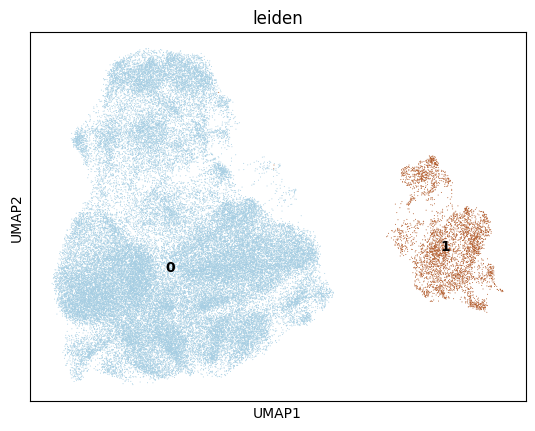

In [17]:
res = 0.02
sc.pp.neighbors(adata,n_neighbors=10,n_pcs=30)
sc.tl.umap(adata)
sc.tl.leiden(adata,resolution=res,n_iterations=2)
sc.pl.umap(adata, color=['leiden'], palette='Paired',legend_loc='on data', save=f'_{studyID}_leiden_res{res}.pdf')    

/Users/yelin.zhao/opt/anaconda3/envs/py3_9_R4_30/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/Users/yelin.zhao/opt/anaconda3/envs/py3_9_R4_30/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/Users/yelin.zhao/opt/anaconda3/envs/py3_9_R4_30/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap'

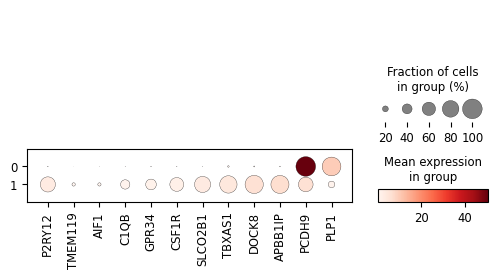

In [22]:
# supplementary figure
goi=['P2RY12','TMEM119','AIF1','C1QB','CX3R1','GPR34','CSF1R','SLCO2B1','TBXAS1','DOCK8','APBB1IP','PCDH9','PLP1']

goi_in_adata=[gene for gene in goi if gene in adata.var_names]
sc.pl.dotplot(adata, goi_in_adata, groupby="leiden",save=f'{studyID}_goi_res{res}_check_microgliaMarker.pdf')

#### Plot CD22 and BHLE41

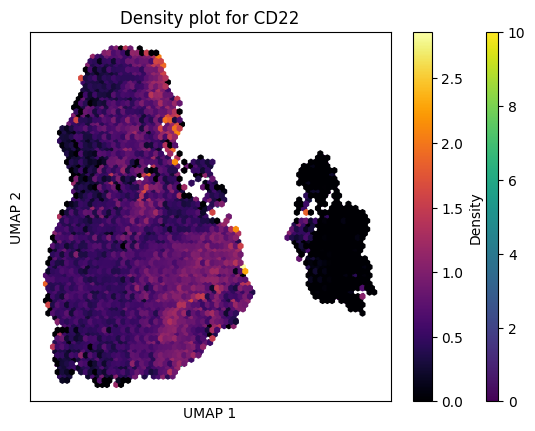

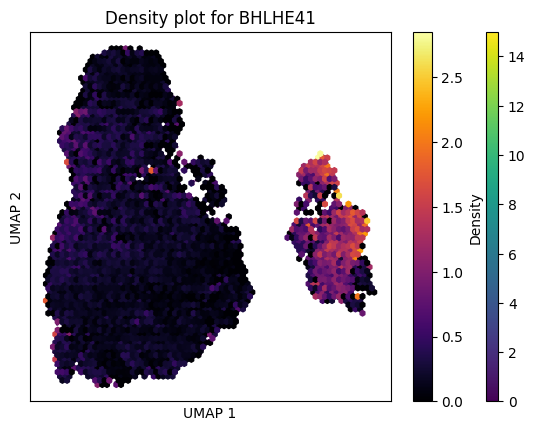

In [23]:
# Importing necessary libraries
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

# Define the markers you are interested in
markers = ["CD22",'BHLHE41']

# Loop over each marker to create a density plot on UMAP
for marker in markers:
    # Create a UMAP scatter plot colored by marker expression
    sc.pl.umap(adata, color=marker, show=False, cmap='viridis', legend_loc=None,s=20)
    
    # Overlay density (this step is similar to Nebulosa, but done manually)
    ax = plt.gca()  # Get current axis
    
    # Extract UMAP coordinates
    x = adata.obsm['X_umap'][:, 0]  # UMAP 1 coordinates
    y = adata.obsm['X_umap'][:, 1]  # UMAP 2 coordinates
    
    # Extract expression levels of the marker
    expression = adata[:, marker].X.toarray().flatten()
    
   # Create a 2D histogram / density plot
    hexbin_plot = ax.hexbin(x, y, C=expression, gridsize=70, cmap='inferno', reduce_C_function=np.mean, mincnt=1)

    # Set axis labels and title
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.title(f'Density plot for {marker}')

    # Add the colorbar with the mappable hexbin plot
    plt.colorbar(hexbin_plot, label='Density')
    
    # Save or show the figure
    plt.savefig(f'figures/umap_density_{studyID}_{marker}.pdf')
    plt.show()

## Extract microglia

In [25]:
adata_m = adata[adata.obs['cell_type']=='microglial cell', :]
adata_m

View of AnnData object with n_obs × n_vars = 3930 × 18742
    obs: 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'is_primary_data', 'Class', 'Subclass', 'Supertype', 'Age at death', 'donor_id', 'suspension_type', 'Fraction mitochrondrial UMIs', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'dataset', 'nCount_RNA', 'nFeature_RNA', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'GeneID', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_d

#### Remove macrophages

/Users/yelin.zhao/opt/anaconda3/envs/py3_9_R4_30/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/yelin.zhao/opt/anaconda3/envs/py3_9_R4_30/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


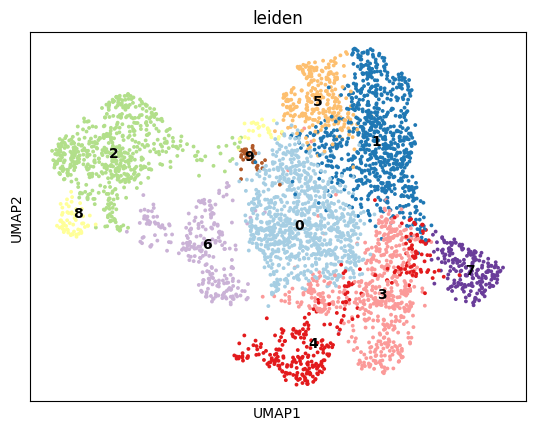

In [28]:
res = 0.5
sc.pp.neighbors(adata_m,n_neighbors=10,n_pcs=30)
sc.tl.umap(adata_m)
sc.tl.leiden(adata_m,resolution=res,n_iterations=2)
sc.pl.umap(adata_m, color=['leiden'], palette='Paired',legend_loc='on data')    

/Users/yelin.zhao/opt/anaconda3/envs/py3_9_R4_30/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/Users/yelin.zhao/opt/anaconda3/envs/py3_9_R4_30/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/Users/yelin.zhao/opt/anaconda3/envs/py3_9_R4_30/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap'

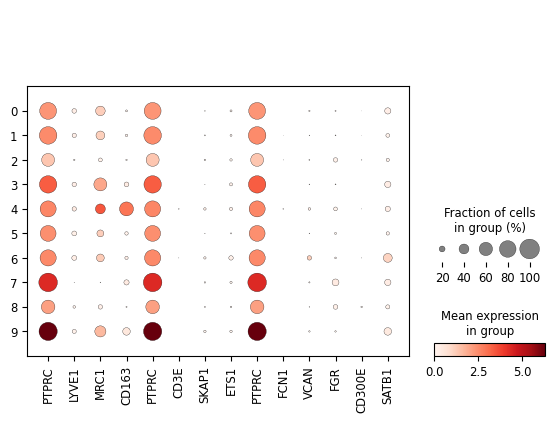

In [32]:
goi=['PTPRC', 'LYVE1', 'MRC1', 'CD163','PTPRC', 'CD3E', 'CD79B', 'SKAP1', 'ETS1','PTPRC', 'FCN1', 'VCAN', 'FGR', 'CD300E','SATB1']
goi_in_adata=[gene for gene in goi if gene in adata_m.var_names]
sc.pl.dotplot(adata_m, goi_in_adata, groupby="leiden");

In [35]:
# Remove macrophage cluster 4
clusters_to_remove = ['4']
adata_m = adata_m[~adata_m.obs['leiden'].isin(clusters_to_remove), :]
adata_m

View of AnnData object with n_obs × n_vars = 3630 × 18742
    obs: 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'is_primary_data', 'Class', 'Subclass', 'Supertype', 'Age at death', 'donor_id', 'suspension_type', 'Fraction mitochrondrial UMIs', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'dataset', 'nCount_RNA', 'nFeature_RNA', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'GeneID', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_d

In [1]:
# Reclustering
res = 0.05
import scanpy as sc
import matplotlib.pyplot as plt
sc.pp.highly_variable_genes(adata_m,n_top_genes=n_hvg)
sc.tl.pca(adata_m)
sc.pp.neighbors(adata_m,n_neighbors=10,n_pcs=30)
sc.tl.umap(adata_m)
sc.tl.leiden(adata_m,resolution=res,n_iterations=2)
sc.pl.umap(adata_m, color=['leiden'], palette='Paired',legend_loc='on data', save=f'_{studyID}_microglia_leiden_res{res}.pdf')    

NameError: name 'adata_m' is not defined

#### Supplement figure

/Users/yelin.zhao/opt/anaconda3/envs/py3_9_R4_30/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/Users/yelin.zhao/opt/anaconda3/envs/py3_9_R4_30/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/Users/yelin.zhao/opt/anaconda3/envs/py3_9_R4_30/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap'

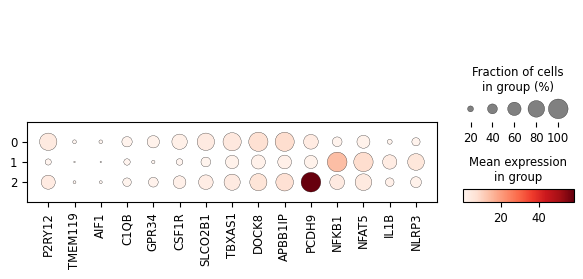

In [47]:
# supplementary figure
goi=['P2RY12','TMEM119','AIF1','C1QB','CX3R1','GPR34','CSF1R','SLCO2B1','TBXAS1','DOCK8','APBB1IP','PCDH9','NFKB1','NFAT5','IL1B','NLRP3']

goi_in_adata=[gene for gene in goi if gene in adata_m.var_names]
sc.pl.dotplot(adata_m, goi_in_adata, groupby="leiden",save=f'{studyID}_microglia_goi_res{res}_check_microgliaMarker.pdf')

#### Identify marker gene

    Start to identify marker gene DS12


/Users/yelin.zhao/opt/anaconda3/envs/py3_9_R4_30/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


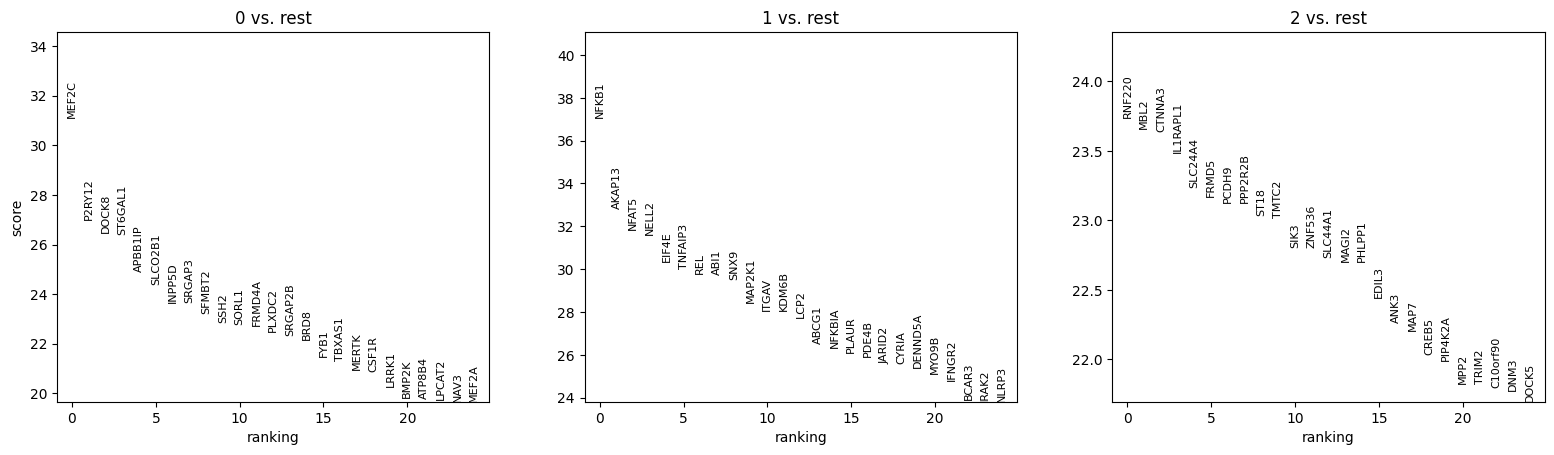

In [45]:
print(f'    Start to identify marker gene {studyID}')
sc.tl.rank_genes_groups(adata_m, "leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata_m, n_genes=25, sharey=False,save=f'{studyID}_clustermarker_res{res}_within_microglia.pdf')
cluster_marker = pd.DataFrame(adata_m.uns["rank_genes_groups"]["names"])
cluster_marker.to_csv(f'{output_dir}/{studyID}_clustermarker_within_microglia.csv')

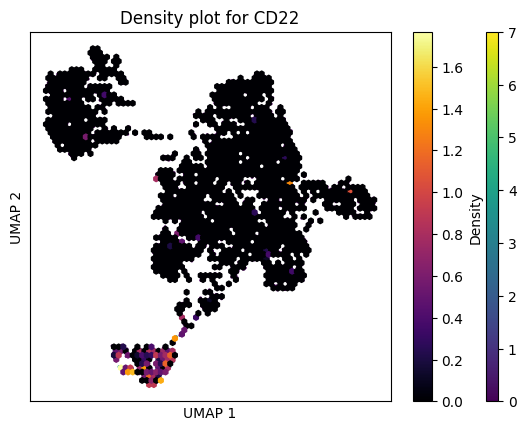

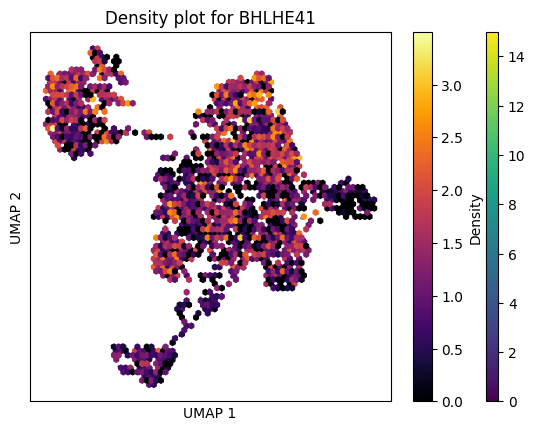

In [48]:
# Importing necessary libraries
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

# Define the markers you are interested in
markers = ["CD22",'BHLHE41']

# Loop over each marker to create a density plot on UMAP
for marker in markers:
    # Create a UMAP scatter plot colored by marker expression
    sc.pl.umap(adata_m, color=marker, show=False, cmap='viridis', legend_loc=None,s=20)
    
    # Overlay density (this step is similar to Nebulosa, but done manually)
    ax = plt.gca()  # Get current axis
    
    # Extract UMAP coordinates
    x = adata_m.obsm['X_umap'][:, 0]  # UMAP 1 coordinates
    y = adata_m.obsm['X_umap'][:, 1]  # UMAP 2 coordinates
    
    # Extract expression levels of the marker
    expression = adata_m[:, marker].X.toarray().flatten()
    
   # Create a 2D histogram / density plot
    hexbin_plot = ax.hexbin(x, y, C=expression, gridsize=70, cmap='inferno', reduce_C_function=np.mean, mincnt=1)

    # Set axis labels and title
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.title(f'Density plot for {marker}')

    # Add the colorbar with the mappable hexbin plot
    plt.colorbar(hexbin_plot, label='Density')
    
    # Save or show the figure
    plt.savefig(f'figures/umap_density_{studyID}_{marker}_within_macrolia.pdf')
    plt.show()